In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pyklip.klip
import pyklip.fakes as fakes
import pyklip.fm as fm
import pyklip.instruments.Instrument as Instrument
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf

# Measure the Astrometry and Photometry of Outer Planet Companion

This notebook will show how to forward model the PSF of the planet through KLIP (since KLIP distorts the planet signal), and then we will use MCMC to measure the posterior location/flux of the planet and Gaussian processes to model the correlated noise in the data. We call this technique BKA and you can read more about it in the pyKLIP docs: http://pyklip.readthedocs.io/en/latest/bka.html.

## First, we must read in the data

Just as is done in the basic KLIP reduction notebook. We won't use the reference star data, but we will use the unocculted star for flux calibration and for our PSF model. 

(6, 101, 101)
(6, 101, 101)
(54, 101, 101)
(6, 101, 101)


Text(0.5, 1.0, 'Unocculted PSF')

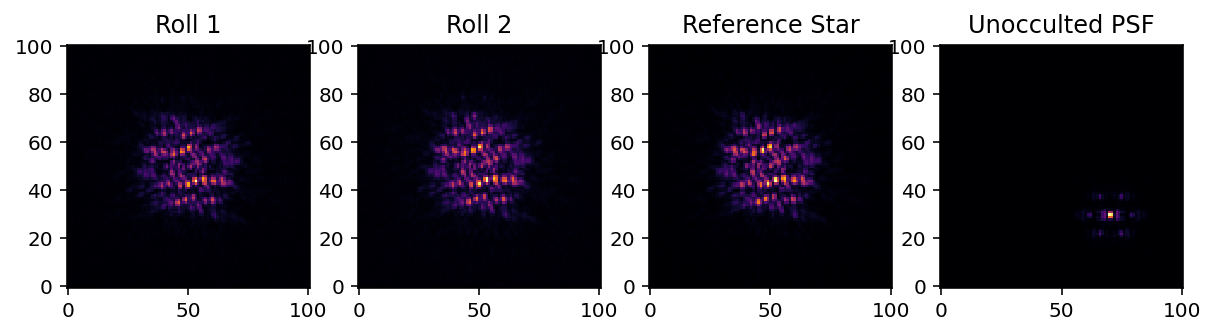

In [2]:
filtername = "f300m"
data_folder = 'old_simulated_data/'

# read in roll 1
with fits.open(data_folder+"NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data
    print(roll1_cube.shape)

# read in roll 2
with fits.open(data_folder+"NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data   
    print(roll2_cube.shape)

# read in ref star
with fits.open(data_folder+"NIRCam_refs_SGD_{0}.fits".format(filtername)) as hdulist:
    ref_cube = hdulist[0].data 
    print(ref_cube.shape)

# read in unocculted PSF
with fits.open(data_folder+"NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    print(psf_cube.shape)  

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,4,1)
ax1.imshow(roll1_cube[0], interpolation="nearest", cmap="inferno")
ax1.invert_yaxis()
ax1.set_title("Roll 1")

ax2 = fig.add_subplot(1,4,2)
ax2.imshow(roll2_cube[0], interpolation="nearest", cmap="inferno")
ax2.invert_yaxis()
ax2.set_title("Roll 2")

ax3 = fig.add_subplot(1,4,3)
ax3.imshow(ref_cube[0], interpolation="nearest", cmap="inferno")
ax3.invert_yaxis()
ax3.set_title("Reference Star")

ax4 = fig.add_subplot(1,4,4)
ax4.imshow(psf_cube[0], interpolation="nearest", cmap="inferno")
ax4.invert_yaxis()
ax4.set_title("Unocculted PSF")

In [3]:
# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees, this is the right sign (trust me)
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

# create the GenericData object. This will standardize the data for pyKLIP
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False # get the right handedness of the data

## Center on the unocculted PSF

So that we have a nicely centered model of the star we can use for PSF modelling

70.45855749153525 29.8360856033007


Text(0.5, 1.0, 'Reference PSF')

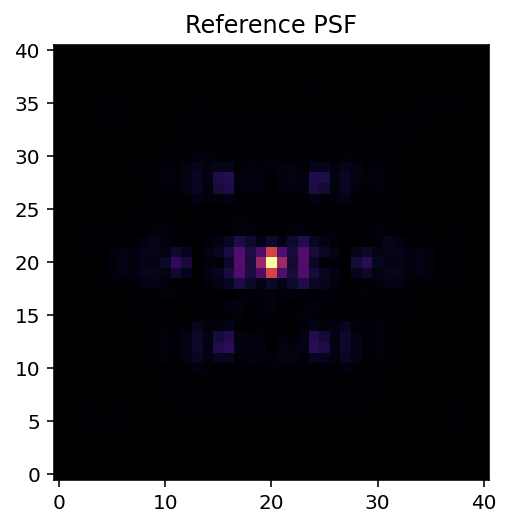

In [4]:
# collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]
print(psf_xcen, psf_ycen)

# recenter PSF to that location
x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])

plt.figure()
plt.imshow(psf_stamp, interpolation="nearest", cmap="inferno")
plt.gca().invert_yaxis()
plt.title("Reference PSF")

## KLIP-FM for forward modelling of outer source

First set up guesses for the location and flux of the planet. Then run the code that generates the forward model of the planet PSF using the unocculted PSF of the star. Note that RDI is not yet working with KLIP-FM, but should be soon (and should make fitting the planet even better)

We'll get a warning about the spline fitting of the PSF being rank deficient. This should be fine.

#### Correcting for coronagraphic throughput

To improve the accuracy of our forward model, we can also account for the effect of JWST's coronograph on light transmission. When initializing the ``fmpsf.FMPlanetPSF`` class, we can provide the optional argument 'field_dependent_correction' which accepts a user provided function to correct for coronagraphic throughput. The signature of the user provided function is (input_stamp: numpy.ndarray, input_dx: numpy.ndarray, input_dy: numpy.ndarray) -> numpy.ndarray. All the numpy arrays in the signature should be 2D. As an example of how this would be done, we'll use the transmission profile of the MASK210 coronagraph (obtained from the Occulting Masks section of this NIRCAM webpage: https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-coronagraphic-occulting-masks-and-lyot-stops).

In [5]:
# Read in the transmission profile csv
mask210 = pd.read_csv("MASK210R.csv", names = ["rad_dist", "trans"])

# Create the throughput correction function
def transmission_corrected(input_stamp, input_dx, input_dy):

    """
    Args:
        input_stamp (array): 2D array of the region surrounding the fake planet injection site
        input_dx (array): 2D array specifying the x distance of each stamp pixel from the center
        input_dy (array): 2D array specifying the y distance of each stamp pixel from the center
        
    Returns:
        output_stamp (array): 2D array of the throughput corrected planet injection site.
        """

    # Calculate the distance of each pixel in the input stamp from the center
    distance_from_center = np.sqrt((input_dx) ** 2 + (input_dy) ** 2)

    # Interpolate to find the transmission value for each pixel in the input stamp (we need to turn the columns into arrays so np.interp can accept them)
    distance = np.array(mask210["rad_dist"])
    transmission = np.array(mask210["trans"])
    
    # Calculate the distance in pixels
    distance_pix = mask210['rad_dist']/0.063

    trans_at_dist = np.interp(distance_from_center, distance_pix, transmission)

    # Reshape the interpolated array to have the same dimensions as the input stamp
    transmission_stamp = trans_at_dist.reshape(input_stamp.shape)

    # Make the throughput correction
    output_stamp = transmission_stamp * input_stamp

    return output_stamp

In [6]:
psf_stamp_input = np.array([psf_stamp for j in range(12)])
planet_sep = 10
input_contrast = 6e-4 
pa = 270


planet_flux = psf_stamp_input * input_contrast

fakes.inject_planet(frames=dataset.input, centers=dataset.centers, inputflux=planet_flux, astr_hdrs=dataset.wcs, radius=planet_sep, pa=pa, field_dependent_correction=transmission_corrected)


In [7]:
# setup FM guesses
numbasis = np.array([1, 3, 10]) # KL basis cutoffs you want to try
guess_dx = 9 # in pxiels (positive is to the left)
guess_dy = 4 # in pixels (positive is up)
guesssep = 10 # estimate of separation in pixels
guesspa = 270 # estimate of position angle, in degrees
guessflux = 6e-4
 # estimated contrast
guessspec = np.array([1]) # braodband, so don't need to guess spectrum

# initialize the FM Planet PSF class
fm_class = fmpsf.FMPlanetPSF(dataset.input.shape, numbasis, guesssep, guesspa, guessflux, np.array([psf_stamp]),
                             np.unique(dataset.wvs), spectrallib_units="contrast", spectrallib=[guessspec], field_dependent_correction = None)


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1172: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=255). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


In [8]:
# PSF subtraction parameters
# You should change these to be suited to your data!
outputdir = "./" # where to write the output files
prefix = "pyklipfm-b-ADI-k50m1" # fileprefix for the output files
annulus_bounds = [[guesssep-20, guesssep+20]] # one annulus centered on the planet
subsections = 1 # we are not breaking up the annulus
padding = 0 # we are not padding our zones
movement = 1 # basically, we want to use the other roll angle for ADI.

# run KLIP-FM
import pyklip.fm as fm
fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement, maxnumbasis=50)

Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 2513.2741228718346 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/jeaadams/JWST-ERS-Pipeline/notebooks


## Load in the forward model and the data and create the fitting object.

KLIP-FM produces both the KLIPed data and the forward model, so that the data and model are reduced with the exact same parameters for consistency. 

The FMAstrometry object fits for both the astrometry and the photometry of the planet. We specify the fitting box size and extract out stamps of the planet in both the data and forward model fot fitting. 

In [9]:
output_prefix = os.path.join(outputdir, prefix)
with fits.open(output_prefix + "-fmpsf-KLmodes-all.fits") as fm_hdu:
    # get FM frame, use KL=7
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']

with fits.open(output_prefix + "-klipped-KLmodes-all.fits") as data_hdu:
    # get data_stamp frame, use KL=7
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]

fitboxsize = 17
fma = fitpsf.FMAstrometry(guesssep, guesspa, fitboxsize)

# generate FM stamp
# padding should be greater than 0 so we don't run into interpolation problems
fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

# generate data_stamp stamp
# not that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
# exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)

/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


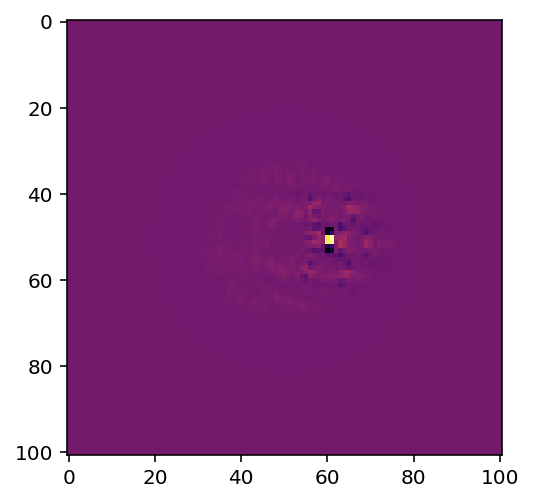

In [10]:
plt.imshow(fm_frame, cmap = 'inferno')

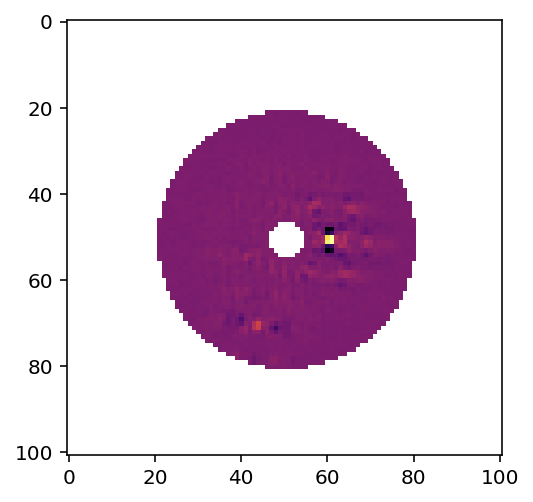

In [11]:
plt.imshow(data_frame, cmap = 'inferno')

## Set up the Gaussian process kernel, initialize priors, run MCMC

We will specify that we are using a Matern $\nu=3/2$ kernel as the analytical form to model the correlated noise in the data. This kernel has wider tails than a standard squared exponential kernel. Basically, with this kernel, we specify how much correlation there is between two pixels as a function of the distance between these two pixels. We will keep one free parameter, the correlation length, which we will fit with MCMC. Longer correlation lengths means that pixels separated by a given distance will be more correlated.

We also will initialize the bounds for the priors. We will give 1 pixel wiggle room for the planet's true location, and a factor or 10 wiggle room for the planet's flux (and also for the correlation length of the Gaussian process).

To run MCMC, we will use the affine invariant sampler that comes with the `emcee` package. This could take several minutes. 

In [12]:
# set kernel
corr_len_guess = 3. # in pixels, our guess for the correlation length
corr_len_label = r"$l$" # label for this variable.
fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

# set prior boundson parameters
x_range = 1.0 # pixels
y_range = 1.0 # pixels
flux_range = 1. # flux can vary by an order of magnitude
corr_len_range = 1. # between 0.3 and 30
fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

# run MCMC fit
fma.fit_astrometry(nwalkers=100, nburn=200, nsteps=800, numthreads=2)

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


## Plot the fits

First we will plot the MCMC walkers to make sure they are converged

Text(0, 0.5, '$l$')

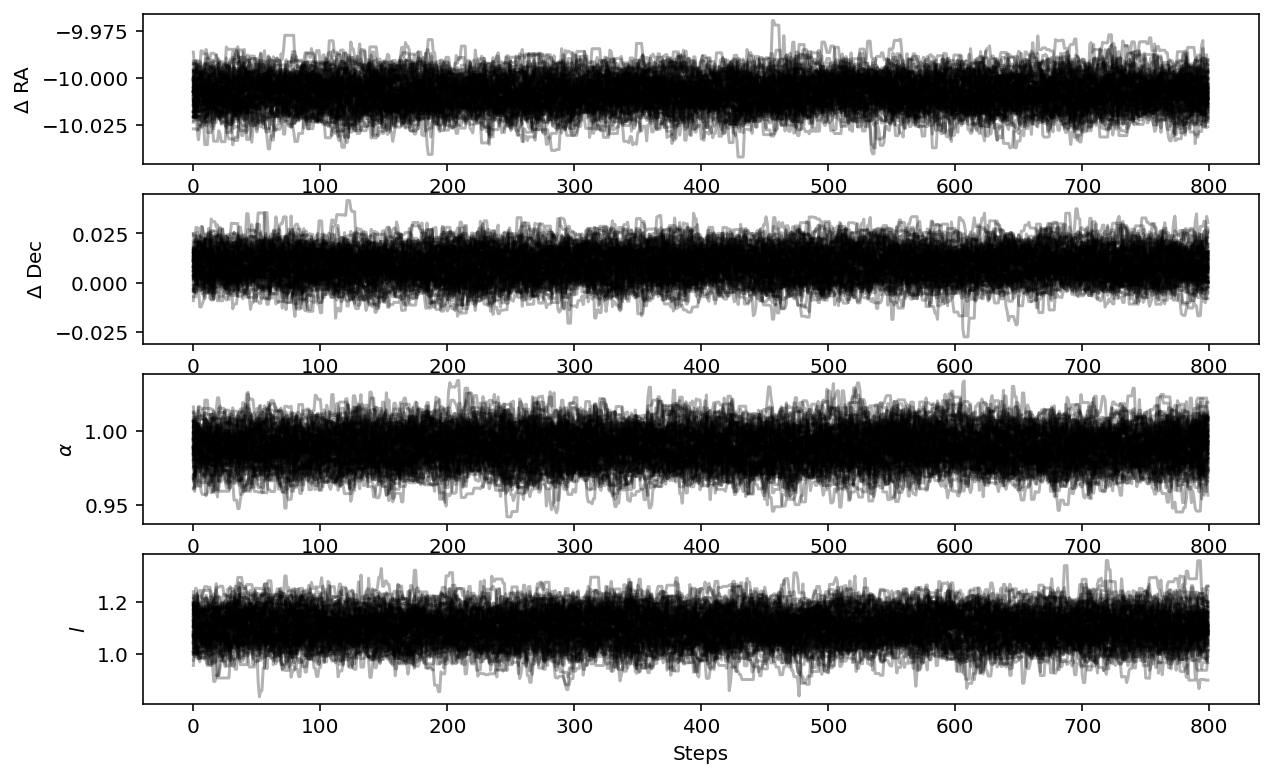

In [13]:
fig = plt.figure(figsize=(10,8))

# grab the chains from the sampler
chain = fma.sampler.chain

# plot RA offset
ax1 = fig.add_subplot(511)
ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)
ax1.set_xlabel("Steps")
ax1.set_ylabel(r"$\Delta$ RA")

# plot Dec offset
ax2 = fig.add_subplot(512)
ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
ax2.set_xlabel("Steps")
ax2.set_ylabel(r"$\Delta$ Dec")

# plot flux scaling
ax3 = fig.add_subplot(513)
ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
ax3.set_xlabel("Steps")
ax3.set_ylabel(r"$\alpha$")

# plot hyperparameters.. we only have one for this example: the correlation length
ax4 = fig.add_subplot(514)
ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
ax4.set_xlabel("Steps")
ax4.set_ylabel(r"$l$")

## Plot the comparison between the data and the best fit model

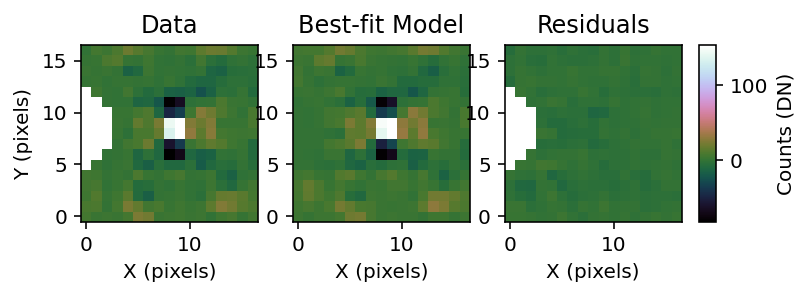

In [14]:
fig = plt.figure()
fig = fma.best_fit_and_residuals(fig=fig)

## Plot the posterior plots for the parameters

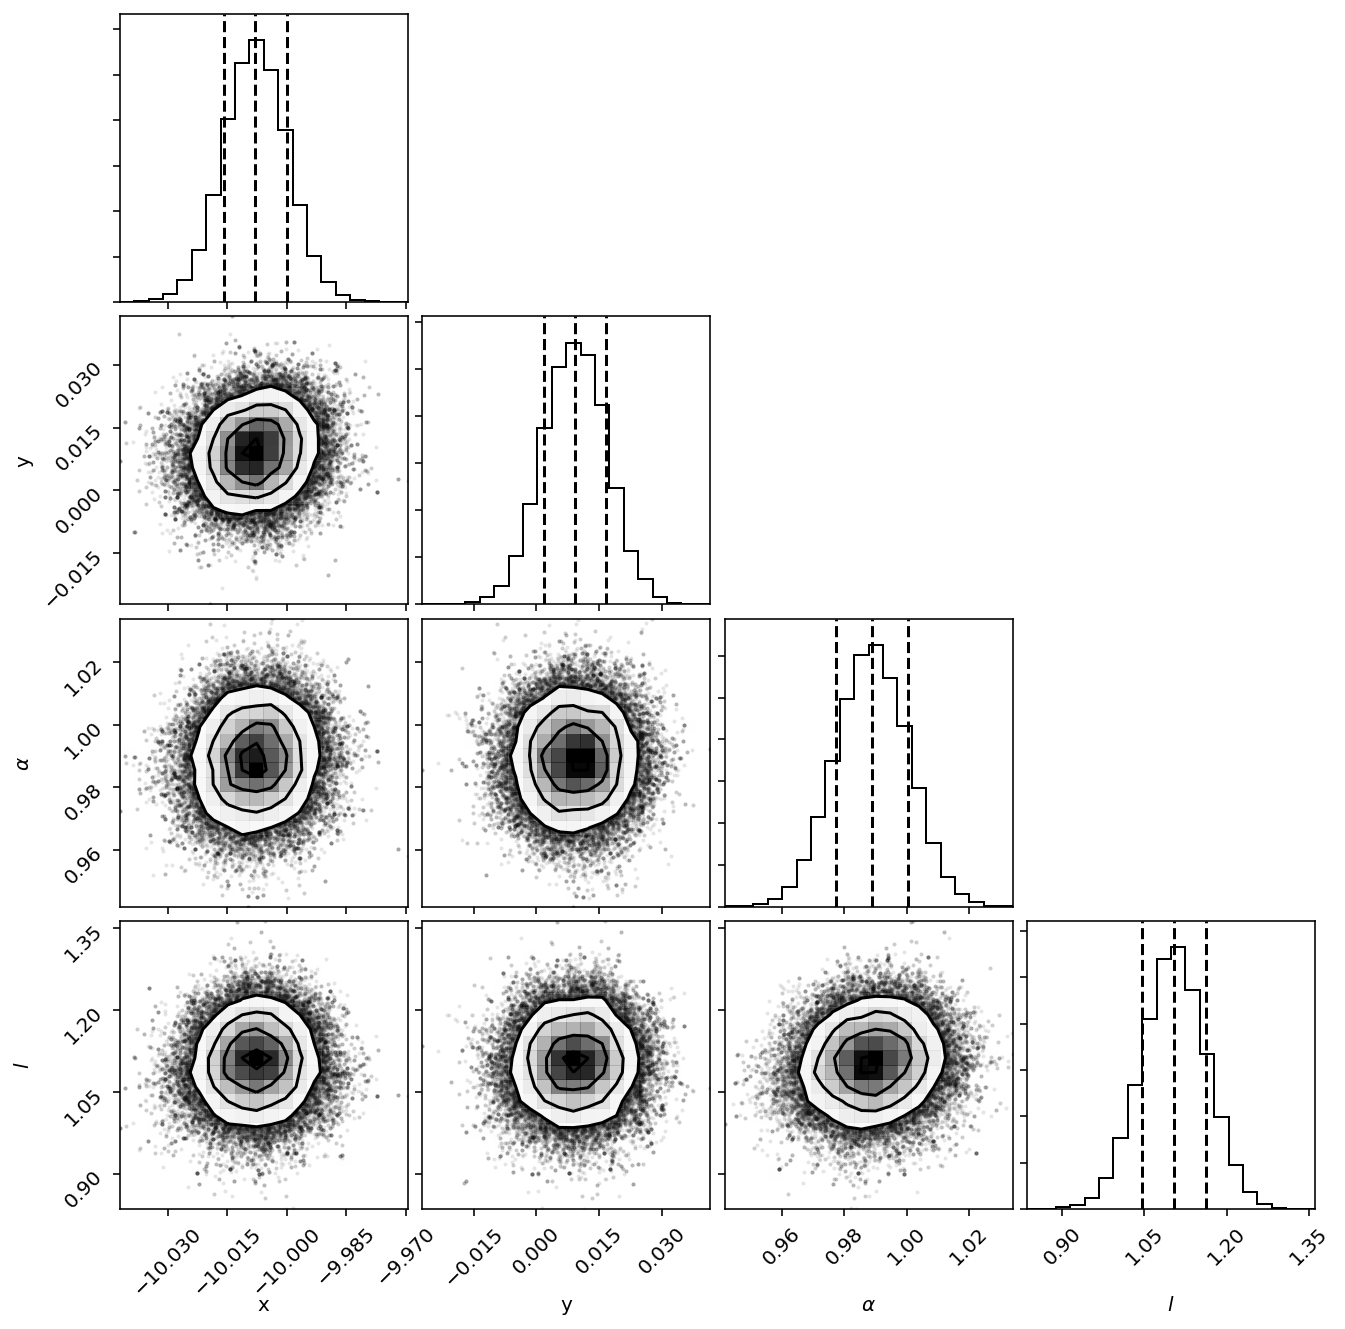

In [15]:
fig = fma.make_corner_plot()

## Finally, we can read off the planet's location and flux

In [16]:
print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fma.raw_RA_offset.bestfit, fma.raw_RA_offset.error,
                                                                                    fma.raw_Dec_offset.bestfit, fma.raw_Dec_offset.error))

print("Planet Flux is {0} +/- {1}".format(fma.raw_flux.bestfit*guessflux, fma.raw_flux.error*guessflux))


Planet Raw RA offset is -10.00792422266791 +/- 0.007867081811504306, Raw Dec offset is 0.009259606497494133 +/- 0.007497872565309649
Planet Flux is 0.0005933570880325356 +/- 6.918030286573139e-06


In [17]:
 fma.covar_params[0].bestfit

1.1039714908604